# Lab 5. Extreme Eigenvalues and Spiked Model.

### Due date: Friday 03/04 at 10:59 pm

In [2]:
!pip install powerlaw

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import powerlaw
import scipy.linalg
import scipy.sparse.linalg
import scipy.special
from scipy import stats
pi = np.pi

## Part 1. Extreme Eigenvalues of Covariance Matrix

#### Theorem (Bai and Yin, 1993). 

Let $X_n$ denote a $p\times n$ random matrix whose entries are independent identically distributed random variables with mean $0$ and variance $1$. Define the $p \times p$ Wishart matrix
$$
Y_{n}= \frac{1}{n} X_n X_n^{T} \in \mathbb{R}^{p\times p}.
$$ 
Denote the largest and smallest eigenvalue of $Y_n$ by $\lambda^{(n)}_{+}$ and $\lambda^{(n)}_{-}$,respectively. Additionally, we assume that the entries $(X_{n})_{ij}$ of the (random noise) feature matrix have finite $4$th moments, as $n, p \to \infty$ with $\gamma = \lim_{n\to \infty}(p/n) < 1$, we have
$$
\lambda^{(n)}_{+} \stackrel{a.s.}{\to} (1 + \sqrt{\gamma})^2, \quad \lambda^{(n)}_{-} \stackrel{a.s.}{\to} (1 - \sqrt{\gamma})^2,
$$
That is, the largest and smallest eigenvalues converge almost surely to the edges of the support of the Marcenko–Pastur density.
* Remark. Actually, we have a more precise description, Tracy–Widom law, to characterize the behaviour of extreme eigenvalues.

In [32]:
gamma = 0.09
N = np.array([50, 100, 150, 200, 300, 500, 700, 1000, 2000, 5000])
P = gamma*N
P = P.astype(int)

eig_max = np.array([])
eig_min = np.array([])

for i in range(len(N)):
    X = np.random.normal(0,1,(P[i],N[i]))
    Y = X@(X.T)/N[i]
    eigvals, eigvecs = np.linalg.eigh(Y)
    eig_max = np.append(eig_max, np.max(eigvals))
    
    """
    TODO: 1. append the minimum eigenvalue to eig_min
    """
    ### BEGIN SOLUTION
    eig_min = np.append(eig_min, np.min(eigvals))
    ### END SOLUTION

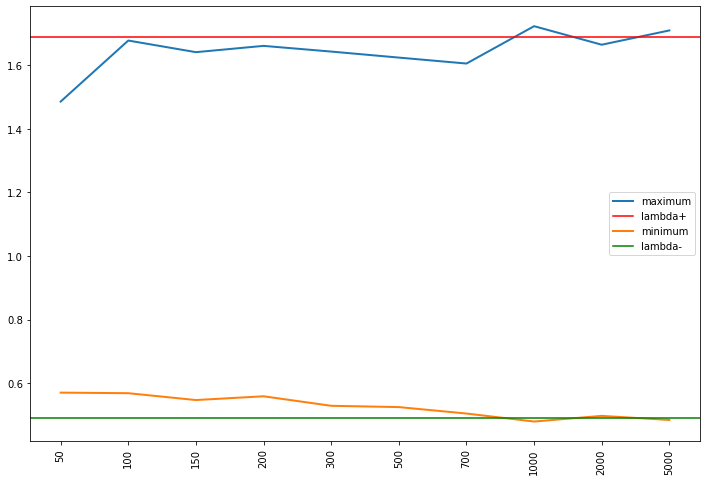

In [33]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(len(eig_max)), eig_max, lw=2, label='maximum')
plt.axhline(y=(1 + np.sqrt(gamma))**2, color='r', linestyle='-', label='lambda+')
plt.plot(np.arange(len(eig_min)), eig_min, lw=2, label='minimum')
"""
TODO: 2. plot the horizontal line of (1 - sqrt(gamma))^2
"""
### BEGIN SOLUTION
plt.axhline(y=(1 - np.sqrt(gamma))**2, color='g', linestyle='-', label='lambda-')
### END SOLUTION

plt.xticks(np.arange(len(eig_max)), N, rotation='vertical')
_ = plt.legend()

#### Existence of 4th Moments

In previous theorem, we we assume that the entries $(X_{n})_{ij}$ have finite $4$th moments. Then we will have the convergence of the largest and smallest eigenvalue as $n, p \to \infty$ with $\gamma = \lim_{n\to \infty}(p/n) < 1$. The existence of 4th Moments does matter.

Let's consider the `powerlaw` distribution instead with probability density function
$$
f(x)=3*x^{-4}\mathbf{1}_{\{x\geq 1\}}(x)\,,
$$
where the first moment $\mathbb{E}[X] = \int xf(x)dx = 3/2$ and second moment $\mathbb{E}[X^2] = \int x^2f(x)dx = 3$, while the fourth moment is not finite. The theorem doesn't apply anymore. That is, we don't expect the largest and the smallest eigenvalues to converge to the edge of the support of the Marcenko–Pastur density.

In [23]:
gamma = 0.09
N = np.arange(1500, 2000, 50)
P = gamma*N
P = P.astype(int)

beta = 4

# define powerlaw distribution
powerlaw_distribution = powerlaw.Power_Law(xmin=1., parameters=[beta], discrete=False)

eig_max = np.array([])
eig_min = np.array([])

for i in range(len(N)):
    samples = powerlaw_distribution.generate_random(P[i]*N[i])
    samples = (samples - np.mean(samples))/np.sqrt(np.var(samples))  #standardise the data
    X = np.array(samples).reshape((P[i], N[i]))
    Y = X@(X.T)/N[i]
    eigvals, eigvecs = np.linalg.eigh(Y)
    eig_max = np.append(eig_max, np.max(eigvals))
    eig_min = np.append(eig_min, np.min(eigvals))

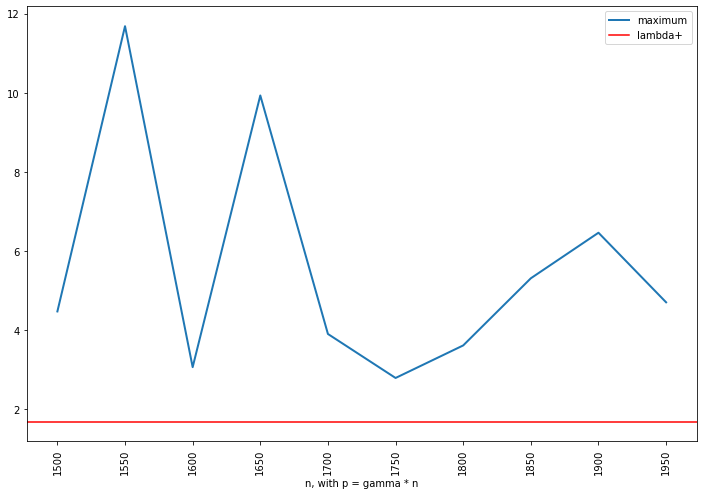

In [30]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(len(eig_max)), eig_max, lw=2, label='maximum')
plt.axhline(y=(1 + np.sqrt(gamma))**2, color='r', linestyle='-', label='lambda+')
plt.xticks(np.arange(len(eig_max)), N, rotation='vertical')
plt.xlabel('n')
_ = plt.legend()

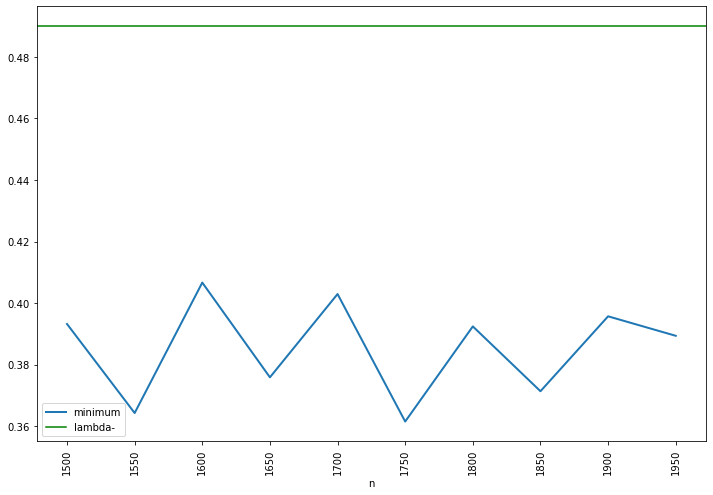

In [31]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(len(eig_min)), eig_min, lw=2, label='minimum')
plt.axhline(y=(1 - np.sqrt(gamma))**2, color='g', linestyle='-', label='lambda-')
plt.xticks(np.arange(len(eig_min)), N, rotation='vertical')
plt.xlabel('n')
_ = plt.legend()

## Part 2. Spiked Covariance Models

#### Theorem.

Let $X_n$ denote a $p\times n$ random matrix whose entries are independent identically distributed random variables with mean $0$ and variance $1$. Let $C = I_{n} + D_{r}$ be a rank-$r$ diagonal perturbation of the identity matrix with fixed $r$. Define the $p \times p$  `spiked Wishart matrix`
$$
Y_{n}= \frac{1}{n} X_n C X_n^{T} \in \mathbb{R}^{p\times p}.
$$ and let $\lambda^{(n)}_{1},\,\lambda^{(n)}_{2},\,\dots ,\,\lambda^{(n)}_{p}$ denote the eigenvalues of $Y_{n}$ (viewed as random variables). Finally, consider the random measure
$$
\mu_{p}(A)={\frac{1}{p}}\#\left\{\lambda^{(n)}_{j}\in A\right\},\quad A\subset \mathbb {R}.
$$

Assume that $p,\,n\,\to \,\infty$  so that the ratio $p/n\,\to \,\gamma \in (0,+\infty )$. Then $\mu _{p}\,\to \,\mu$ in distribution, where

$$
\mu(A) = \begin{cases} 
        (1-\frac{1}{\gamma}) \mathbf{1}_{0\in A} + \nu(A),& \text{if } \gamma >1,\\
        \nu(A),& \text{if } 0\leq \gamma \leq 1,
        \end{cases}
$$
and
$$
d\nu (x)= {\frac {\sqrt {(\lambda_{+}-x)(x-\lambda _{-})}}{2\pi\gamma x}}\,\mathbf{1}_{x\in [\lambda _{-},\lambda _{+}]}\,dx
$$
with $\lambda_{\pm }=(1\pm {\sqrt {\lambda }})^{2}$.

* Remark. As far as the limit histogram of eigenvalues is concerned, spiked models made no difference. The limit of the proportion of eigenvalues in a given interval tells us nothing about the extreme eigenvalues. In first part, the Theorem(Bai and Yin) proved that, in the non-spiked case ($C = I_n$), the largest eigenvalue sticks to the edges of the Marcenko–Pastur density, that is, all eigenvalues are inside the interval $[(1 - \sqrt{\gamma})^2, (1 + \sqrt{\gamma})^2]$. However, this fails for spiked covariance models($C = I_{n} + D_{r}$): they have `outlier eigenvalues`.

In [34]:
r = 4
gamma = 0.5
n = 500
p = int(gamma*n)

X = np.array(np.random.randn(p,n))
eig_D = np.array([4.2, 8.7, 11.8, 20.9])
D = np.diag(np.concatenate([eig_D, np.zeros(n-len(eig_D))]))

"""
TODO: 3. Compute C = I_n + D and Y = XCX.T/n
"""
### BEGIN SOLUTION
C = np.eye(n) + D
Y = X@C@(X.T)/n
### END SOLUTION
eigen_Y = np.sort(np.linalg.eigh(Y)[0])

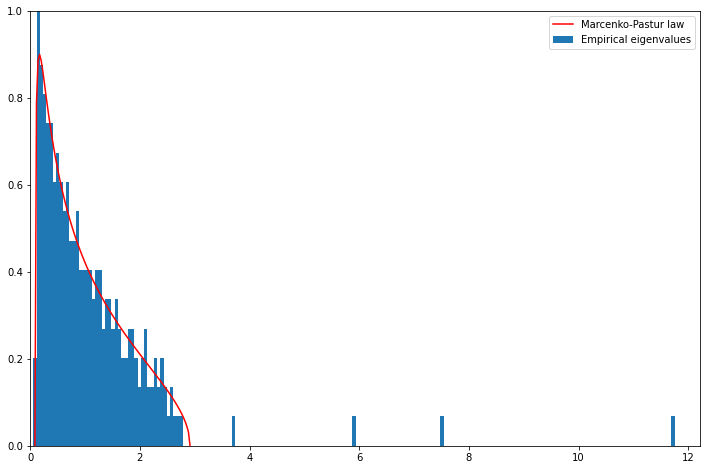

In [37]:
edges = np.linspace(np.min(eigen_Y) - 0.1, np.max(eigen_Y) + 0.1, 200)

a = (1 - np.sqrt(gamma))**2
b = (1 + np.sqrt(gamma))**2

plt.figure(figsize=(12,8))
plt.hist(eigen_Y, bins=edges,weights=1/(p*(edges[1]-edges[0]))*np.ones(p),label='Empirical eigenvalues')
edges_MP = np.linspace(a,b,100)
mu = np.sqrt((edges_MP-a)*(b-edges_MP) )/(2*pi*gamma)
plt.plot(edges_MP,mu/edges_MP,'r',label='Marcenko-Pastur law')
plt.gca().set_xlim(0,np.max(eigen_Y)+0.5)
plt.gca().set_ylim(0,1)
_ = plt.legend()

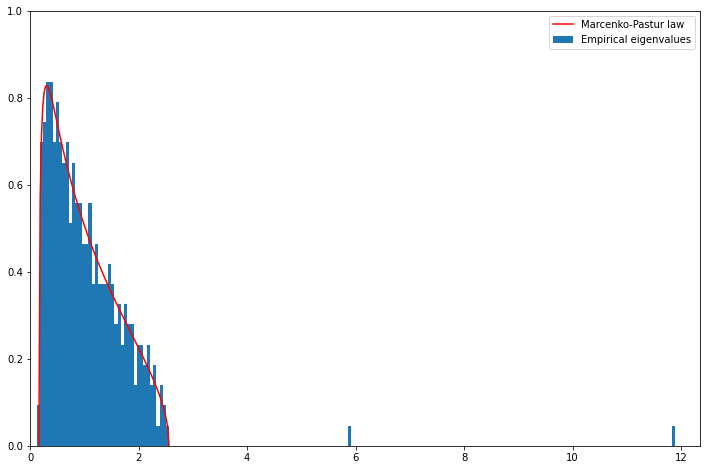

In [39]:
"""
TODO: 4. Following the procedure above, try another example by setting gamma = 0.36, n = 1000 
        and eig_D = np.array([13, 27])
"""
### BEGIN SOLUTION
gamma = 0.36
n = 1000
p = int(gamma*n)

eig_D = np.array([13, 27])
D = np.diag(np.concatenate([eig_D, np.zeros(n-len(eig_D))]))
C = np.eye(n) + D

X = np.array(np.random.randn(p,n))
Y = X@C@(X.T)/n
eigen_Y = np.sort(np.linalg.eigh(Y)[0])

edges = np.linspace(np.min(eigen_Y) - 0.1, np.max(eigen_Y) + 0.1, 200)
a = (1 - np.sqrt(gamma))**2
b = (1 + np.sqrt(gamma))**2

plt.figure(figsize=(12,8))
plt.hist(eigen_Y, bins=edges,weights=1/(p*(edges[1]-edges[0]))*np.ones(p),label='Empirical eigenvalues')
edges_MP = np.linspace(a,b,100)
mu = np.sqrt((edges_MP-a)*(b-edges_MP) )/(2*pi*gamma)
plt.plot(edges_MP,mu/edges_MP,'r',label='Marcenko-Pastur law')
plt.gca().set_xlim(0,np.max(eigen_Y)+0.5)
plt.gca().set_ylim(0,1)
_ = plt.legend()

### END SOLUTION

## Submission Instructions


### Download Code Portion
* Restart the kernel and run all the cells to make sure your code works.
* Save your notebook using File > Save and Checkpoint.
* Use File > Downland as > PDF via Latex.
* Download the PDF file and confirm that none of your work is missing or cut off. 
* **DO NOT** simply take pictures using your phone. 

### Submitting ###
* Submit the assignment to Lab1 on Gradescope. 
* **Make sure to assign only the pages with your implementation to the question.**